In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['pdf.use14corefonts'] = True

# Unsupervised exploration of feature representations

In [2]:
df = pd.read_csv('../datafiles/chexpert/chexpert.resample.test.csv')

white = 'White'
asian = 'Asian'
black = 'Black'

In [3]:
labels = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices']


## Embeddings

In [4]:
model = 'densenet-resample'
num_features = 1024 # DenseNet-121
# num_features = 512 # ResNet-34
data_dir = '../prediction/chexpert/disease/' + model
out_format = 'png' # use pdf for high quality vector format output
rasterized_scatter = True

In [5]:
embs = pd.read_csv(data_dir + '/embeddings.test.csv')
embeds = np.array(embs.iloc[:,0:num_features])
n, m = embeds.shape
print(embeds.shape)

(114720, 1024)


### PCA

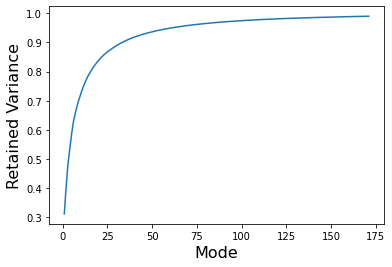

(114720, 171)


In [6]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.99, whiten=False)
embeds_pca = pca.fit_transform(embeds)

mu = pca.mean_
U = pca.components_.T
D = pca.singular_values_**2 / (n - 1)
exp_var = pca.explained_variance_ratio_

fig, ax = plt.subplots()
ax.plot(range(1,len(exp_var)+1),np.cumsum(exp_var))
ax.set_xlabel('Mode', fontsize=16)
ax.set_ylabel('Retained Variance', fontsize=16)
plt.show()

df['PCA Mode 1'] = embeds_pca[:,0]
df['PCA Mode 2'] = embeds_pca[:,1]
df['PCA Mode 3'] = embeds_pca[:,2]
df['PCA Mode 4'] = embeds_pca[:,3]

print(embeds_pca.shape)

### t-SNE (this may take a few minutes)

In [7]:
from sklearn.manifold import TSNE
embeds_tsne = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(embeds_pca)

df['t-SNE Dimension 1'] = embeds_tsne[:,0]
df['t-SNE Dimension 2'] = embeds_tsne[:,1]

### Logits

In [8]:
preds = pd.read_csv(data_dir + '/predictions.test.csv') # for single task models
# preds = pd.read_csv(data_dir + '/predictions.test.disease.csv') # for multitask model
logits = np.stack([preds['logit_0'],preds['logit_10']]).transpose()

In [9]:
df['Logit - ' + labels[0]] = logits[:,0]
df['Logit - ' + labels[10]] = logits[:,1]

### Sampling

In [10]:
n_samples = 1000

df_white = df[df['race'] == white].sample(n=n_samples)
df_asian = df[df['race'] == asian].sample(n=n_samples)
df_black = df[df['race'] == black].sample(n=n_samples)

sample_test = pd.concat([df_white, df_asian, df_black])
sample_test.to_csv(model + '.embeddings.csv')

### Plotting

In [11]:
sample_test = pd.read_csv(model + '.embeddings.csv')

# Replicate entries for having capital letters in plots
sample_test['Disease'] = sample_test['disease']
sample_test['Sex'] = sample_test['sex']
sample_test['Age'] = sample_test['age']
sample_test['Race'] = sample_test['race']

In [12]:
alpha = 0.6
style = 'o'
markersize = 40
kind = 'scatter'

method = 'logit'
xdat = 'Logit - ' + labels[0]
ydat = 'Logit - ' + labels[10]

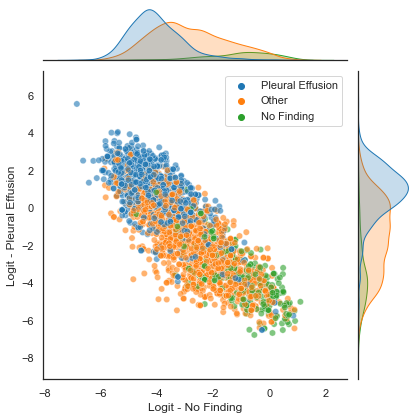

In [13]:
label = 'Disease'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, hue_order=['Pleural Effusion', 'Other', 'No Finding'], data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
plt.savefig(method + '-' + model + '-disease.' + out_format, bbox_inches='tight', dpi=300)
fig.ax_joint.legend(loc='upper right')
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

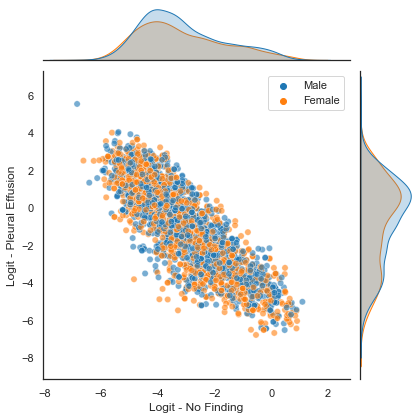

In [14]:
label = 'Sex'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, hue_order=['Male', 'Female'], data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-sex.' + out_format, bbox_inches='tight', dpi=300)

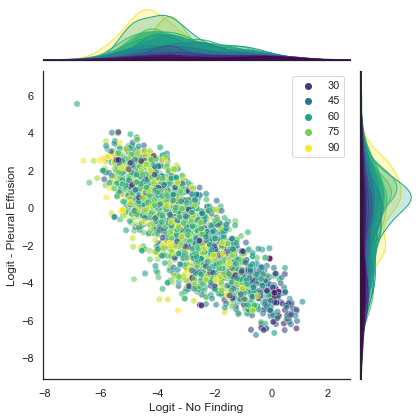

In [15]:
label = 'Age'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, palette='viridis', data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-age.' + out_format, bbox_inches='tight', dpi=300)

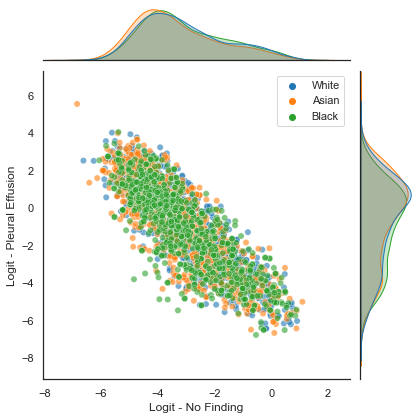

In [16]:
label = 'Race'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, xlim=xlim, ylim=ylim, marker=style, s=markersize, alpha=alpha, data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-race.' + out_format, bbox_inches='tight', dpi=300)

In [17]:
method = 'tsne'
xdat = 't-SNE Dimension 1'
ydat = 't-SNE Dimension 2'

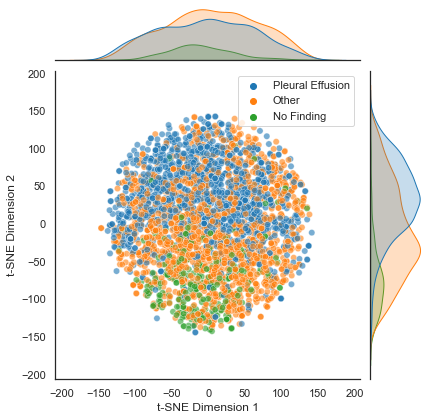

In [18]:
label = 'Disease'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, hue_order=['Pleural Effusion', 'Other', 'No Finding'], data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-disease.' + out_format, bbox_inches='tight', dpi=300)
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

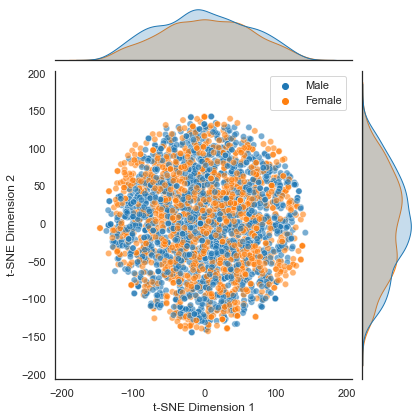

In [19]:
label = 'Sex'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, hue_order=['Male', 'Female'], data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-sex.' + out_format, bbox_inches='tight', dpi=300)

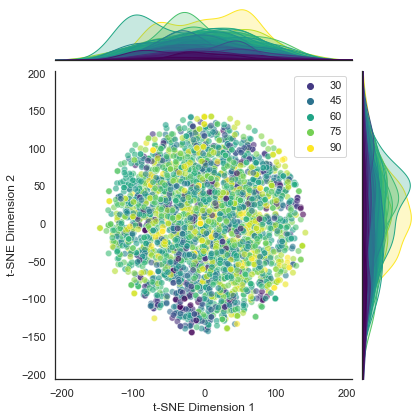

In [20]:
label = 'Age'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, palette='viridis', data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-age.' + out_format, bbox_inches='tight', dpi=300)

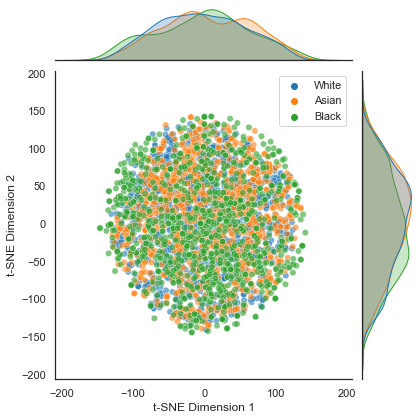

In [21]:
label = 'Race'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, xlim=xlim, ylim=ylim, marker=style, s=markersize, alpha=alpha, data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-race.' + out_format, bbox_inches='tight', dpi=300)

In [22]:
method = 'pca'
xdat = 'PCA Mode 1'
ydat = 'PCA Mode 2'

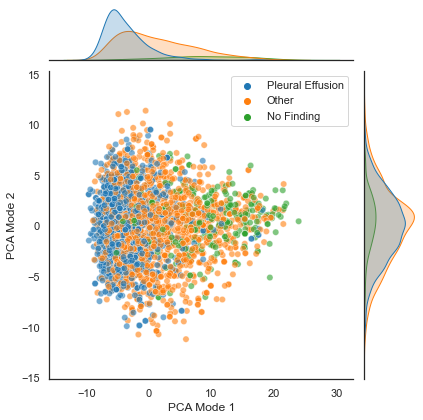

In [23]:
label = 'Disease'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, hue_order=['Pleural Effusion', 'Other', 'No Finding'], data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-disease-mode-1+2.' + out_format, bbox_inches='tight', dpi=300)
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

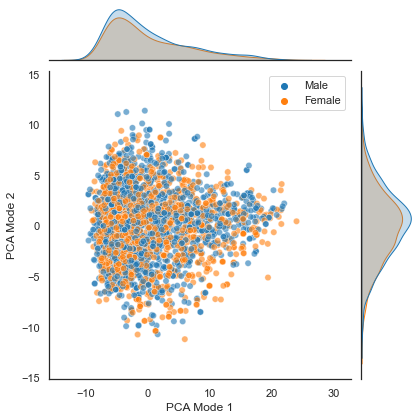

In [24]:
label = 'Sex'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, hue_order=['Male', 'Female'], data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-sex-mode-1+2.' + out_format, bbox_inches='tight', dpi=300)

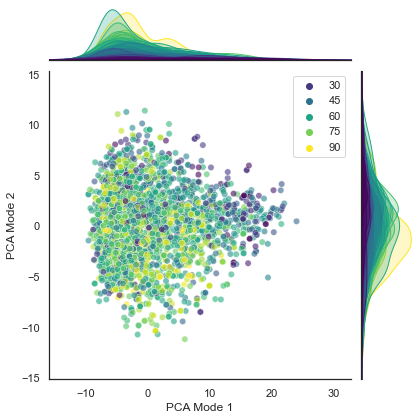

In [25]:
label = 'Age'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, palette='viridis', data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-age-mode-1+2.' + out_format, bbox_inches='tight', dpi=300)

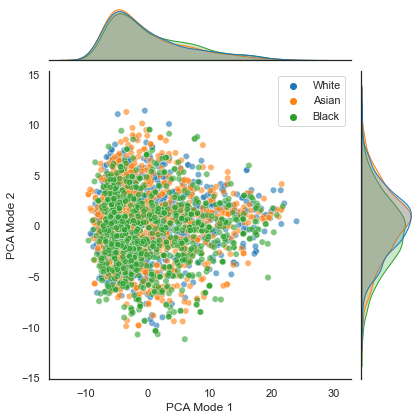

In [26]:
label = 'Race'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, xlim=xlim, ylim=ylim, marker=style, s=markersize, alpha=alpha, data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-race-mode-1+2.' + out_format, bbox_inches='tight', dpi=300)

In [27]:
method = 'pca'
xdat = 'PCA Mode 3'
ydat = 'PCA Mode 4'

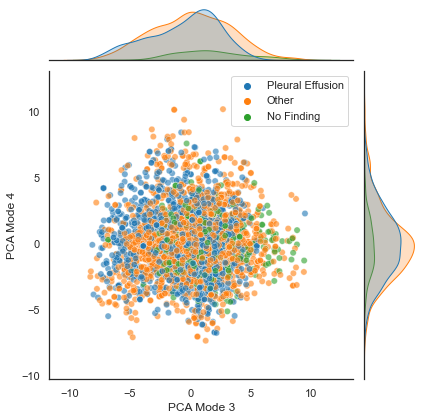

In [28]:
label = 'Disease'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, hue_order=['Pleural Effusion', 'Other', 'No Finding'], data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-disease-mode-3+4.' + out_format, bbox_inches='tight', dpi=300)
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

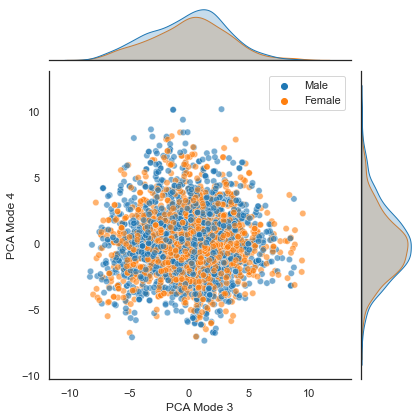

In [29]:
label = 'Sex'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, hue_order=['Male', 'Female'], data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-sex-mode-3+4.' + out_format, bbox_inches='tight', dpi=300)

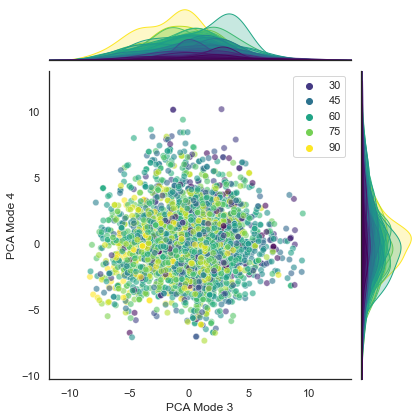

In [30]:
label = 'Age'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, palette='viridis', data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-age-mode-3+4.' + out_format, bbox_inches='tight', dpi=300)

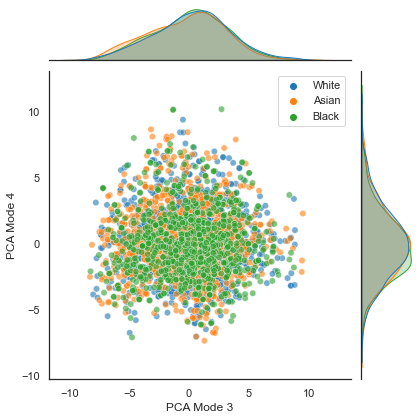

In [31]:
label = 'Race'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, xlim=xlim, ylim=ylim, marker=style, s=markersize, alpha=alpha, data=sample_test, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-race-mode-3+4.' + out_format, bbox_inches='tight', dpi=300)

### Statistical tests

In [32]:
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
np.set_printoptions(suppress=True,formatter={'float_kind': '{:f}'.format})

In [33]:
sample_test = pd.read_csv(model + '.embeddings.csv')

In [34]:
def stats_tests(marginal, samples):
    df_white = samples[samples['race'] == white]
    df_asian = samples[samples['race'] == asian]
    df_black = samples[samples['race'] == black]
    df_female = samples[samples['sex'] == 'Female']
    df_male = samples[samples['sex'] == 'Male']
    df_nofind = samples[samples['disease_label'] == 0]
    df_pleural = samples[samples['disease_label'] == 1]

    res_np = stats.ks_2samp(np.array(df_pleural[marginal]), np.array(df_nofind[marginal]))
    res_wa = stats.ks_2samp(np.array(df_asian[marginal]), np.array(df_white[marginal]))
    res_ab = stats.ks_2samp(np.array(df_black[marginal]), np.array(df_asian[marginal]))
    res_bw = stats.ks_2samp(np.array(df_white[marginal]), np.array(df_black[marginal]))
    res_mf = stats.ks_2samp(np.array(df_female[marginal]), np.array(df_male[marginal]))

    return [res_np.pvalue, res_wa.pvalue, res_ab.pvalue, res_bw.pvalue, res_mf.pvalue]

In [35]:
pvals_pca1 = stats_tests('PCA Mode 1', sample_test)
pvals_pca2 = stats_tests('PCA Mode 2', sample_test)
pvals_pca3 = stats_tests('PCA Mode 3', sample_test)
pvals_pca4 = stats_tests('PCA Mode 4', sample_test)
pvals_log0 = stats_tests('Logit - No Finding', sample_test)
pvals_log10 = stats_tests('Logit - Pleural Effusion', sample_test)

In [36]:
pvals = np.array([pvals_pca1, pvals_pca2, pvals_pca3, pvals_pca4, pvals_log0, pvals_log10])

In [37]:
res = multipletests(pvals.flatten(), alpha=0.05, method='fdr_by', is_sorted=False, returnsorted=False)

In [38]:
print('Rejected null hypothesis')
print(np.array(res[0]).reshape((6,5)))

Rejected null hypothesis
[[ True False  True False False]
 [ True False  True  True False]
 [ True  True False False False]
 [False False False False False]
 [ True  True  True False False]
 [ True False  True  True False]]


In [39]:
print('Adjusted p-values')
print(np.array(res[1]).reshape((6,5)))

Adjusted p-values
[[0.000000 1.000000 0.018699 0.422803 1.000000]
 [0.010111 1.000000 0.000000 0.000000 0.253950]
 [0.000000 0.023904 0.290019 1.000000 1.000000]
 [0.117347 1.000000 0.422803 0.168079 0.147338]
 [0.000000 0.030525 0.000977 1.000000 0.175250]
 [0.000000 1.000000 0.000019 0.000253 0.239921]]
